In [1]:
import numpy as np
import matplotlib.pyplot as plt
import muram as mio
from astropy.io import fits
import pyflct
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
from matplotlib import font_manager
import matplotlib as mpl
font_path = '/home/mistflow/.fonts/cmunrm.ttf'  # Your font path goes here
#font_path = '/usr/share/fonts/opentype/urw-base35/NimbusRoman-Italic.otf'
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)
mpl.rcParams["font.size"] = 12
mpl.rcParams['axes.formatter.useoffset'] = False
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = prop.get_name()
#plt.rc('text', usetex=True)
plt.rc('axes', unicode_minus=False)

In [3]:
from scipy.stats import pearsonr
from scipy.ndimage import gaussian_filter
from scipy.stats import linregress

In [4]:
def temporal_avg(data_in, start, end):
    tmp_avg = np.mean(data_in[start:end+1], axis = 0)
    return tmp_avg

In [5]:
def mean_v_from_file(file):
    v_x = fits.open(file)[0].data
    v_x.shape
    v_x = v_x[0:90]
    v_x = np.mean(v_x, axis=0)
    small = np.where(v_x < -6.5)
    v_x[small] = -6.5
    big = np.where(v_x > 6.5)
    v_x[big] = 6.5
    return v_x

def mean_vy_from_file(file):
    v_x = fits.open(file)[1].data
    v_x.shape
    v_x = v_x[0:90]
    v_x = np.mean(v_x, axis=0)
    small = np.where(v_x < -6.5)
    v_x[small] = -6.5
    big = np.where(v_x > 6.5)
    v_x[big] = 6.5
    return v_x

<h2>12. 03. 2025.</h2>

<p>Here we want to check results of FLCT tracking applied to magnetic field inferred using Milne-Eddington inversion</p>

In [6]:
Vx_ME_FeI = fits.open("pyFLCT_vx_vy_fwhm_600_dt_30_Bz_FeI_tracked.fits")[0].data
Vy_ME_FeI = fits.open("pyFLCT_vx_vy_fwhm_600_dt_30_Bz_FeI_tracked.fits")[1].data

In [7]:
np.shape(Vx_ME_FeI)

(30, 768, 768)

In [8]:
Vxm1 = fits.open("Velocities_TAU_0_1.fits")[1].data # Vy from Velocities.fits as originally thought
Vym1 = fits.open("Velocities_TAU_0_1.fits")[0].data # Vx from Velocities.fits as originally thought
Vxm1 = Vxm1[::3,::2,::2]/1E5
Vym1 = Vym1[::3,::2,::2]/1E5
Vxm1 = Vxm1.transpose(0, 2, 1)
Vym1 = Vym1.transpose(0, 2, 1)

In [9]:
Vxm2 = fits.open("Velocities_TAU_0_010.fits")[1].data # Vy from Velocities.fits as originally thought
Vym2 = fits.open("Velocities_TAU_0_010.fits")[0].data # Vx from Velocities.fits as originally thought
Vxm2 = Vxm2[::3,::2,::2]/1E5
Vym2 = Vym2[::3,::2,::2]/1E5
Vxm2 = Vxm2.transpose(0, 2, 1)
Vym2 = Vym2.transpose(0, 2, 1)

In [10]:
Vx_Bz1 = fits.open("pyFLCT_vx_vy_fwhm_600_dt_30_logTaum1Bz_tracked.fits")[0].data
Vy_Bz1 = fits.open("pyFLCT_vx_vy_fwhm_600_dt_30_logTaum1Bz_tracked.fits")[1].data
Vx_Bz1 = Vx_Bz1[:30,::2,::2]
Vy_Bz1 = Vy_Bz1[:30,::2,::2]

In [11]:
Vx_Bz2 = fits.open("pyFLCT_vx_vy_fwhm_600_dt_30_logTaum2Bz_tracked.fits")[0].data
Vy_Bz2 = fits.open("pyFLCT_vx_vy_fwhm_600_dt_30_logTaum2Bz_tracked.fits")[1].data
Vx_Bz2 = Vx_Bz2[:30,::2,::2]
Vy_Bz2 = Vy_Bz2[:30,::2,::2]

In [12]:
np.shape(Vx_Bz2)

(30, 768, 768)

In [13]:
import seaborn as sns

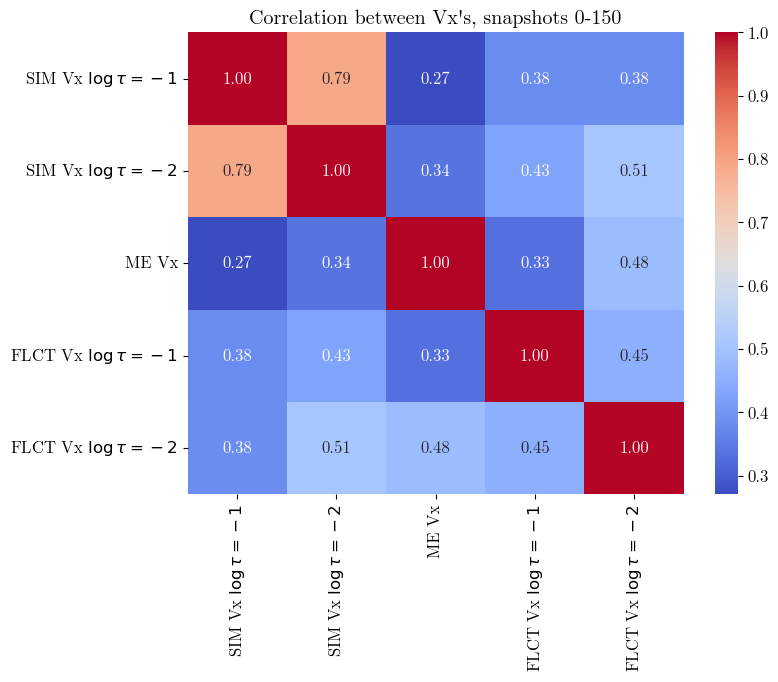

In [14]:
correlation_matrix = np.corrcoef([Vxm1[0,:,:].ravel(), Vxm2[0, :,:].ravel(),
                     Vx_ME_FeI[0,:,:].ravel(), Vx_Bz1[0,:,:].ravel(), 
                     Vx_Bz2[0,:,:].ravel()]) 

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm',
            xticklabels=['SIM Vx $\log\\tau = -1$', 'SIM Vx $\log\\tau = -2$', 'ME Vx', 'FLCT Vx $\log\\tau = -1$', 'FLCT Vx $\log\\tau = -2$'],
            yticklabels=['SIM Vx $\log\\tau = -1$', 'SIM Vx $\log\\tau = -2$', 'ME Vx', 'FLCT Vx $\log\\tau = -1$', 'FLCT Vx $\log\\tau = -2$'])
plt.title("Correlation between Vx\'s, snapshots 0-150")
plt.savefig("Vx_FE_cor.png", dpi = 70)
plt.show()

<h3>Averaging</h3>

In [15]:
Vxm1_mean = temporal_avg(Vxm1, 0, 90)
#Vxm1_mean = Vxm1_mean/1E5
Vym1_mean = temporal_avg(Vym1, 0, 90)
#Vym1_mean = Vym1_mean/1E5

In [16]:
Vxm1_filtered600 = gaussian_filter(Vxm1_mean, 22.5, mode = "wrap")
Vym1_filtered600 = gaussian_filter(Vym1_mean, 22.5, mode = "wrap")

In [17]:
Vxm2_mean = temporal_avg(Vxm2, 0, 90)
#Vxm2_mean = Vxm2_mean/1E5
Vym2_mean = temporal_avg(Vym2, 0, 90)
#Vym2_mean = Vym2_mean/1E5

In [18]:
Vxm2_filtered600 = gaussian_filter(Vxm2_mean, 22.5, mode = "wrap")
Vym2_filtered600 = gaussian_filter(Vym2_mean, 22.5, mode = "wrap")

In [19]:
Vx_BzFeI_mean = temporal_avg(Vx_ME_FeI, 0, 90)
Vy_BzFeI_mean = temporal_avg(Vy_ME_FeI, 0, 90)

In [20]:
Vx_Bz1_cor = mean_v_from_file("pyFLCT_vx_vy_fwhm_600_dt_30_logTaum1Bz_tracked.fits")
Vy_Bz1_cor = mean_vy_from_file("pyFLCT_vx_vy_fwhm_600_dt_30_logTaum1Bz_tracked.fits")

In [21]:
Vx_Bz2_cor = mean_v_from_file("pyFLCT_vx_vy_fwhm_600_dt_30_logTaum2Bz_tracked.fits")
Vy_Bz2_cor = mean_vy_from_file("pyFLCT_vx_vy_fwhm_600_dt_30_logTaum2Bz_tracked.fits")

In [22]:
Vx_BzFeI_cor = mean_v_from_file("pyFLCT_vx_vy_fwhm_600_dt_30_Bz_FeI_tracked.fits")
Vy_BzFeI_cor = mean_vy_from_file("pyFLCT_vx_vy_fwhm_600_dt_30_Bz_FeI_tracked.fits")

In [23]:
Vx_Bz1_mean = temporal_avg(Vx_Bz1, 0, 90)
Vy_Bz1_mean = temporal_avg(Vy_Bz1, 0, 90)
#Vx_Bz1_mean = Vx_Bz1_mean[::2,::2]
#Vy_Bz1_mean = Vy_Bz1_mean[::2,::2]

In [24]:
Vx_Bz2_mean = temporal_avg(Vx_Bz2, 0, 90)
Vy_Bz2_mean = temporal_avg(Vy_Bz2, 0, 90)
#Vx_Bz2_mean = Vx_Bz2_mean[::2,::2]
#Vy_Bz2_mean = Vy_Bz2_mean[::2,::2]

In [25]:
Vx_Bz2_cor = Vx_Bz2_cor[::2,::2]
Vy_Bz2_cor = Vy_Bz2_cor[::2,::2]

In [26]:
Vx_Bz1_cor = Vx_Bz1_cor[::2,::2]
Vy_Bz1_cor = Vy_Bz1_cor[::2,::2]

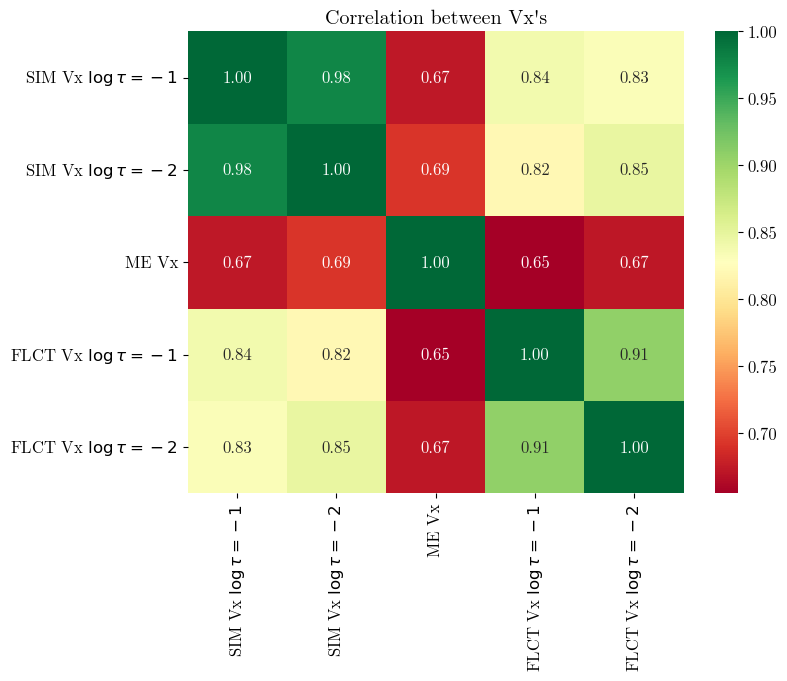

In [27]:
correlation_matrix = np.corrcoef([Vxm1_filtered600[:,:].ravel(), Vxm2_filtered600[:,:].ravel(),
                     Vx_BzFeI_cor[:,:].ravel(), Vx_Bz1_cor[:,:].ravel(), 
                     Vx_Bz2_cor[:,:].ravel()]) 

fig = plt.figure(figsize = (8,6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='RdYlGn',
            xticklabels=['SIM Vx $\log\\tau = -1$', 'SIM Vx $\log\\tau = -2$', 'ME Vx', 'FLCT Vx $\log\\tau = -1$', 'FLCT Vx $\log\\tau = -2$'],
            yticklabels=['SIM Vx $\log\\tau = -1$', 'SIM Vx $\log\\tau = -2$', 'ME Vx', 'FLCT Vx $\log\\tau = -1$', 'FLCT Vx $\log\\tau = -2$'])
plt.title("Correlation between Vx\'s")
plt.savefig("Averaged_cor_vel.png", dpi = 70)
plt.show()

Text(0.5, 1.0, "Correlation between Vx's, corrected")

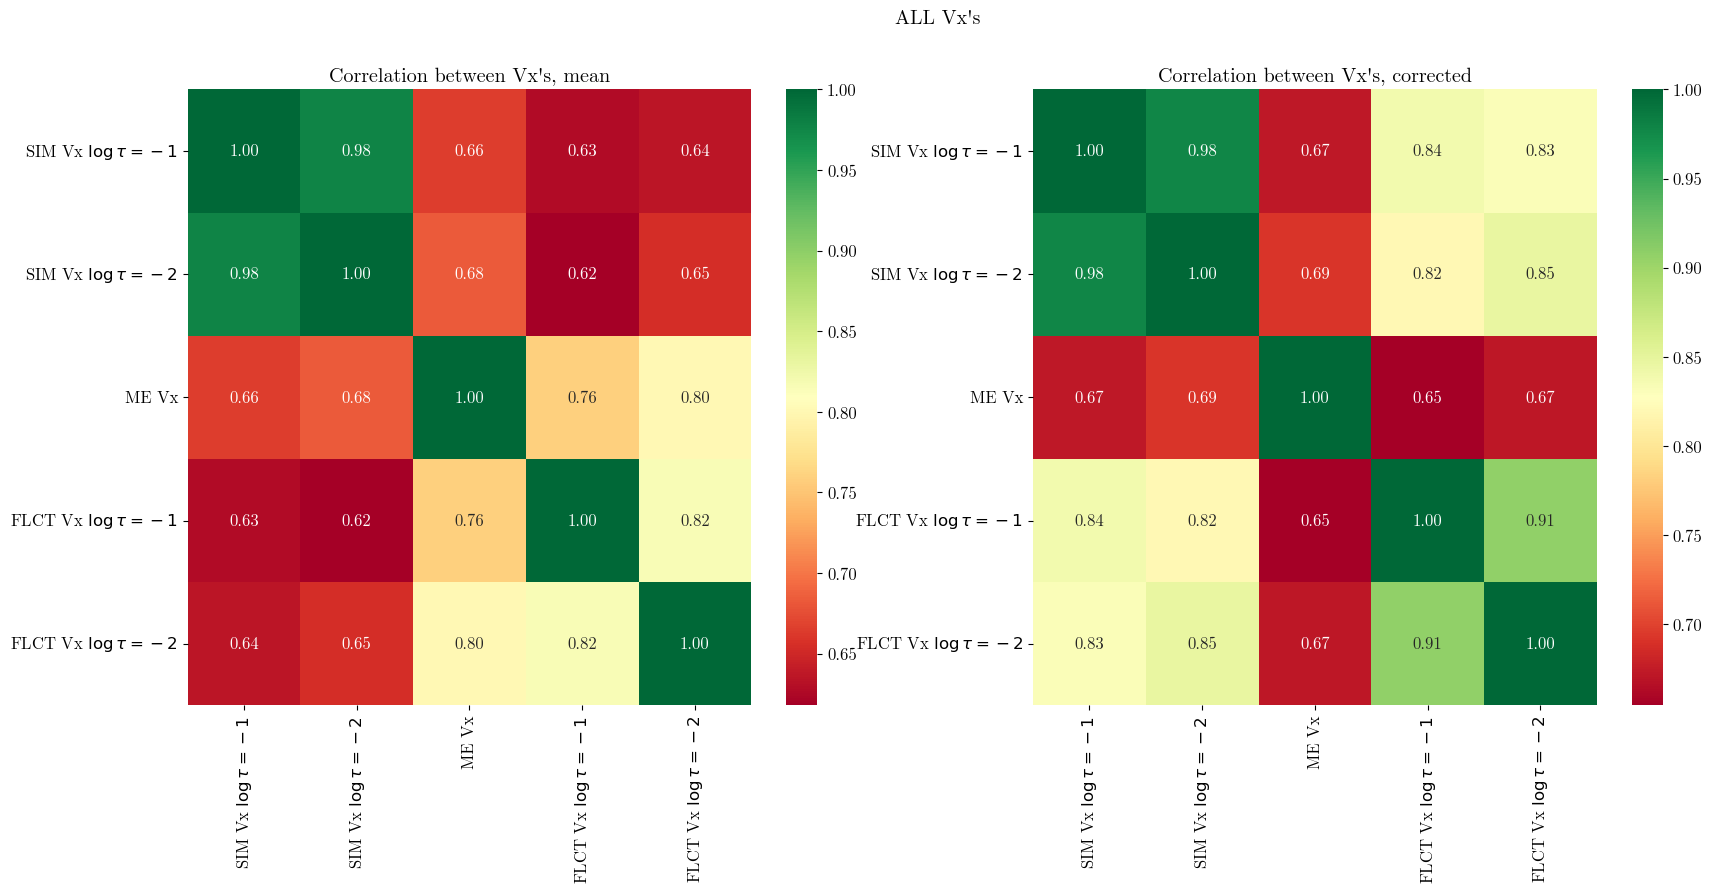

In [28]:
correlation_matrix = np.corrcoef([Vxm1_filtered600[:,:].ravel(), Vxm2_filtered600[:,:].ravel(),
                     Vx_BzFeI_mean[:,:].ravel(), Vx_Bz1_mean[:,:].ravel(), 
                     Vx_Bz2_mean[:,:].ravel()])
fig = plt.figure(figsize = (20,8))
fig.suptitle("ALL Vx\'s")
ax1 = fig.add_subplot(121)
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='RdYlGn',
            xticklabels=['SIM Vx $\log\\tau = -1$', 'SIM Vx $\log\\tau = -2$', 'ME Vx', 'FLCT Vx $\log\\tau = -1$', 'FLCT Vx $\log\\tau = -2$'],
            yticklabels=['SIM Vx $\log\\tau = -1$', 'SIM Vx $\log\\tau = -2$', 'ME Vx', 'FLCT Vx $\log\\tau = -1$', 'FLCT Vx $\log\\tau = -2$'])
plt.title("Correlation between Vx\'s, mean")

correlation_matrix = np.corrcoef([Vxm1_filtered600[:,:].ravel(), Vxm2_filtered600[:,:].ravel(),
                     Vx_BzFeI_cor[:,:].ravel(), Vx_Bz1_cor[:,:].ravel(), 
                     Vx_Bz2_cor[:,:].ravel()])

ax2 = fig.add_subplot(122)
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='RdYlGn',
            xticklabels=['SIM Vx $\log\\tau = -1$', 'SIM Vx $\log\\tau = -2$', 'ME Vx', 'FLCT Vx $\log\\tau = -1$', 'FLCT Vx $\log\\tau = -2$'],
            yticklabels=['SIM Vx $\log\\tau = -1$', 'SIM Vx $\log\\tau = -2$', 'ME Vx', 'FLCT Vx $\log\\tau = -1$', 'FLCT Vx $\log\\tau = -2$'])
plt.title("Correlation between Vx\'s, corrected")
#plt.savefig("Correlatio_0_MgvsFe.png", dpi = 70)

Text(0.5, 1.0, "Correlation between Vy's, corrected")

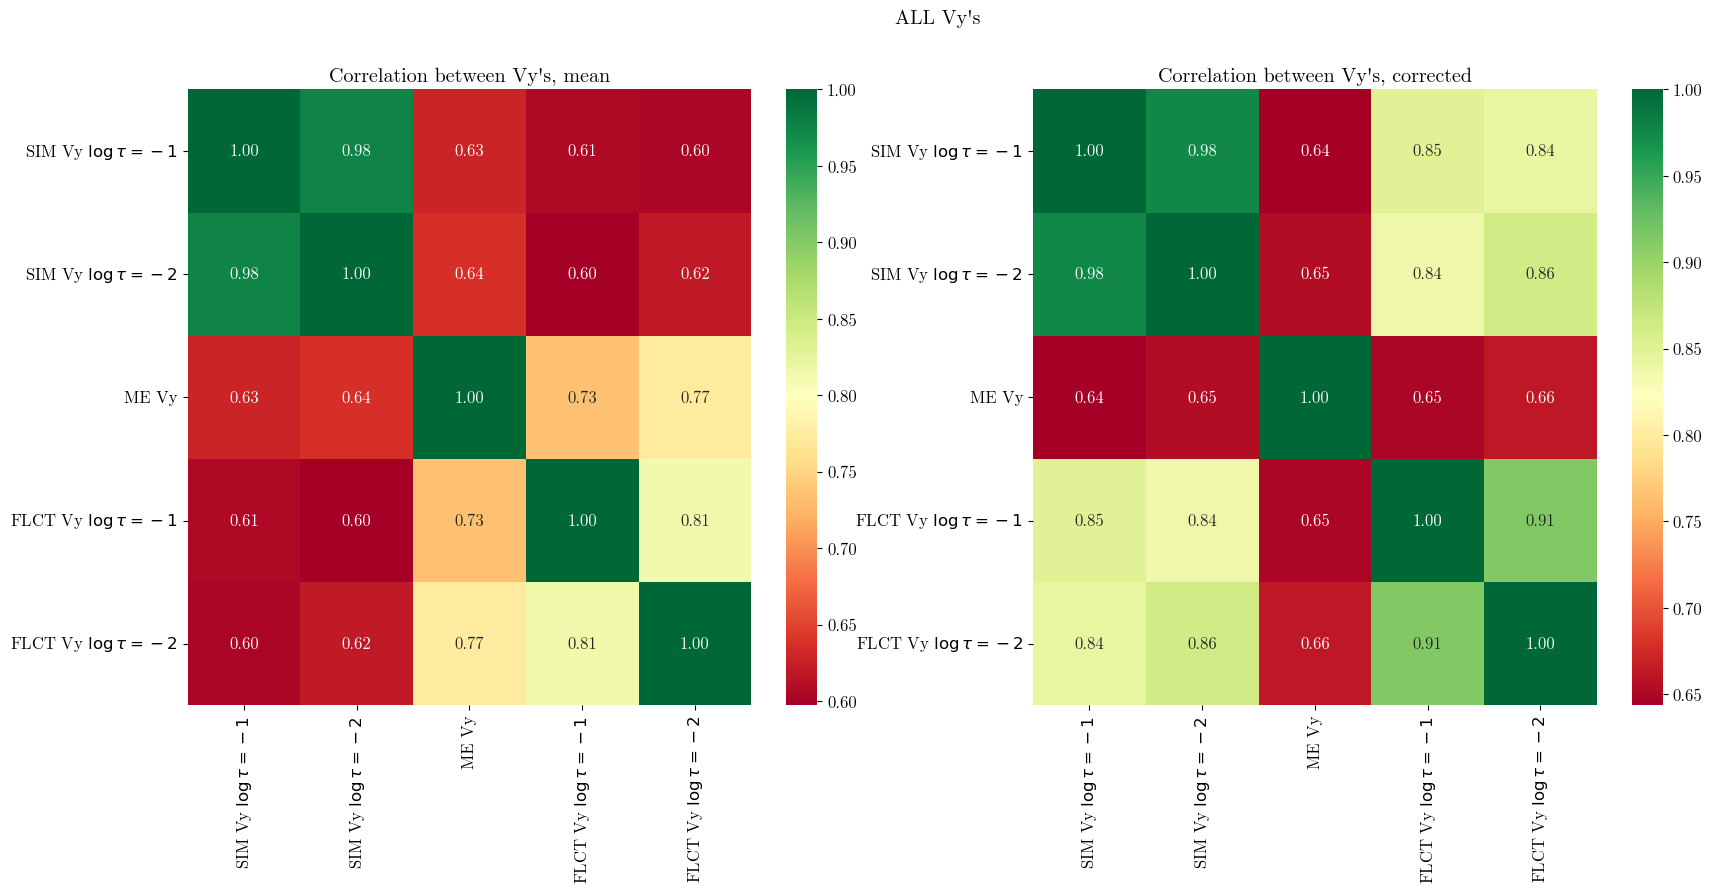

In [29]:
correlation_matrix = np.corrcoef([Vym1_filtered600[:,:].ravel(), Vym2_filtered600[:,:].ravel(),
                     Vy_BzFeI_mean[:,:].ravel(), Vy_Bz1_mean[:,:].ravel(), 
                     Vy_Bz2_mean[:,:].ravel()])
fig = plt.figure(figsize = (20,8))
fig.suptitle("ALL Vy\'s")
ax1 = fig.add_subplot(121)
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='RdYlGn',
            xticklabels=['SIM Vy $\log\\tau = -1$', 'SIM Vy $\log\\tau = -2$', 'ME Vy', 'FLCT Vy $\log\\tau = -1$', 'FLCT Vy $\log\\tau = -2$'],
            yticklabels=['SIM Vy $\log\\tau = -1$', 'SIM Vy $\log\\tau = -2$', 'ME Vy', 'FLCT Vy $\log\\tau = -1$', 'FLCT Vy $\log\\tau = -2$'])
plt.title("Correlation between Vy\'s, mean")

correlation_matrix = np.corrcoef([Vym1_filtered600[:,:].ravel(), Vym2_filtered600[:,:].ravel(),
                     Vy_BzFeI_cor[:,:].ravel(), Vy_Bz1_cor[:,:].ravel(), 
                     Vy_Bz2_cor[:,:].ravel()])

ax2 = fig.add_subplot(122)
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='RdYlGn',
            xticklabels=['SIM Vy $\log\\tau = -1$', 'SIM Vy $\log\\tau = -2$', 'ME Vy', 'FLCT Vy $\log\\tau = -1$', 'FLCT Vy $\log\\tau = -2$'],
            yticklabels=['SIM Vy $\log\\tau = -1$', 'SIM Vy $\log\\tau = -2$', 'ME Vy', 'FLCT Vy $\log\\tau = -1$', 'FLCT Vy $\log\\tau = -2$'])
plt.title("Correlation between Vy\'s, corrected")
#plt.savefig("Correlatio_0_MgvsFe.png", dpi = 70)

<h2>13. 03. 2025</h2>

In [30]:
Vx_ME3_FeI = fits.open("pyFLCT_vx_vy_fwhm_300_dt_30_Bz_FeI_tracked.fits")[0].data
Vy_ME3_FeI = fits.open("pyFLCT_vx_vy_fwhm_300_dt_30_Bz_FeI_tracked.fits")[1].data

In [31]:
Vxm1_filtered300 = gaussian_filter(Vxm1_mean, 11.25, mode = "wrap")
Vym1_filtered300 = gaussian_filter(Vym1_mean, 11.25, mode = "wrap")

In [32]:
Vxm2_filtered300 = gaussian_filter(Vxm2_mean, 11.25, mode = "wrap")
Vym2_filtered300 = gaussian_filter(Vym2_mean, 11.25, mode = "wrap")

In [33]:
Vx_Bz1_cor3 = mean_v_from_file("pyFLCT_vx_vy_fwhm_300_dt_30_logTaum1Bz_tracked.fits")
Vy_Bz1_cor3 = mean_vy_from_file("pyFLCT_vx_vy_fwhm_300_dt_30_logTaum1Bz_tracked.fits")

In [34]:
Vx_Bz2_cor3 = mean_v_from_file("pyFLCT_vx_vy_fwhm_300_dt_30_logTaum2Bz_tracked.fits")
Vy_Bz2_cor3 = mean_vy_from_file("pyFLCT_vx_vy_fwhm_300_dt_30_logTaum2Bz_tracked.fits")

In [35]:
Vx_BzFeI_cor3 = mean_v_from_file("pyFLCT_vx_vy_fwhm_300_dt_30_Bz_FeI_tracked.fits")
Vy_BzFeI_cor3 = mean_vy_from_file("pyFLCT_vx_vy_fwhm_300_dt_30_Bz_FeI_tracked.fits")

In [36]:
Vx_Bz2_cor3 = Vx_Bz2_cor3[::2,::2]
Vy_Bz2_cor3 = Vy_Bz2_cor3[::2,::2]

In [37]:
Vx_Bz1_cor3 = Vx_Bz1_cor3[::2,::2]
Vy_Bz1_cor3 = Vy_Bz1_cor3[::2,::2]

In [38]:
Vx_BzFeI3_mean = temporal_avg(Vx_ME3_FeI, 0, 90)
Vy_BzFeI3_mean = temporal_avg(Vy_ME3_FeI, 0, 90)

Text(0.5, 1.0, "Correlation between Vx's, corrected")

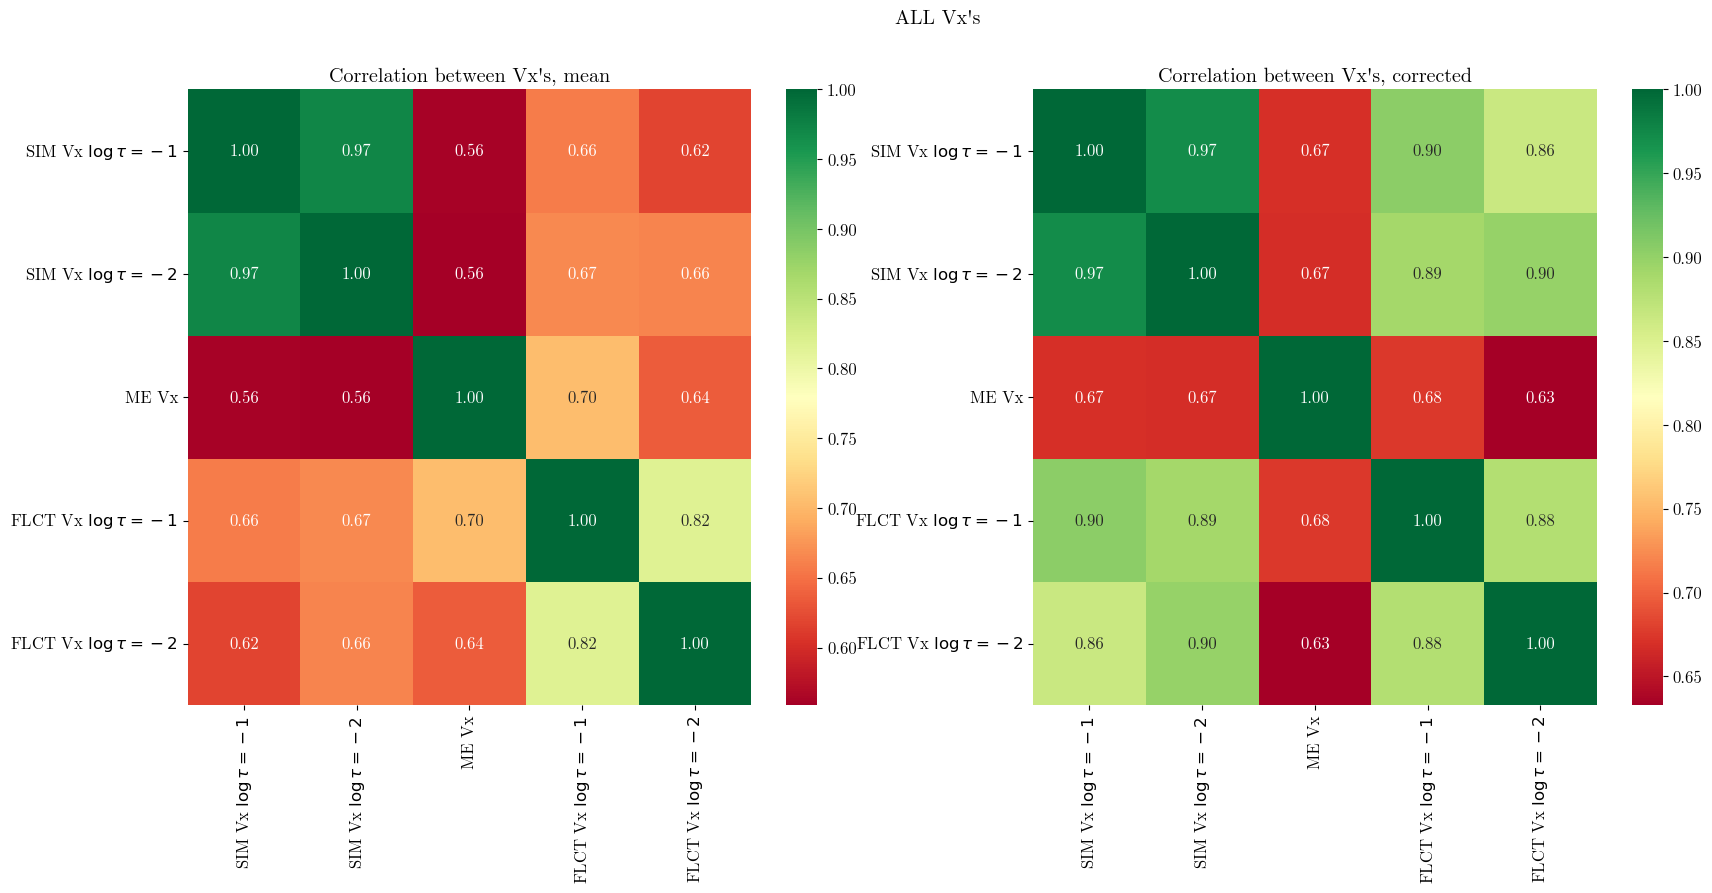

In [39]:
correlation_matrix = np.corrcoef([Vxm1_filtered300[:,:].ravel(), Vxm2_filtered300[:,:].ravel(),
                     Vx_BzFeI3_mean[:,:].ravel(), Vx_Bz1_mean[:,:].ravel(), 
                     Vx_Bz2_mean[:,:].ravel()])
fig = plt.figure(figsize = (20,8))
fig.suptitle("ALL Vx\'s")
ax1 = fig.add_subplot(121)
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='RdYlGn',
            xticklabels=['SIM Vx $\log\\tau = -1$', 'SIM Vx $\log\\tau = -2$', 'ME Vx', 'FLCT Vx $\log\\tau = -1$', 'FLCT Vx $\log\\tau = -2$'],
            yticklabels=['SIM Vx $\log\\tau = -1$', 'SIM Vx $\log\\tau = -2$', 'ME Vx', 'FLCT Vx $\log\\tau = -1$', 'FLCT Vx $\log\\tau = -2$'])
plt.title("Correlation between Vx\'s, mean")

correlation_matrix = np.corrcoef([Vxm1_filtered300[:,:].ravel(), Vxm2_filtered300[:,:].ravel(),
                     Vx_BzFeI_cor3[:,:].ravel(), Vx_Bz1_cor3[:,:].ravel(), 
                     Vx_Bz2_cor3[:,:].ravel()])

ax2 = fig.add_subplot(122)
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='RdYlGn',
            xticklabels=['SIM Vx $\log\\tau = -1$', 'SIM Vx $\log\\tau = -2$', 'ME Vx', 'FLCT Vx $\log\\tau = -1$', 'FLCT Vx $\log\\tau = -2$'],
            yticklabels=['SIM Vx $\log\\tau = -1$', 'SIM Vx $\log\\tau = -2$', 'ME Vx', 'FLCT Vx $\log\\tau = -1$', 'FLCT Vx $\log\\tau = -2$'])
plt.title("Correlation between Vx\'s, corrected")
#plt.savefig("Correlatio_0_MgvsFe.png", dpi = 70)

Text(0.5, 1.0, "Correlation between Vy's, corrected")

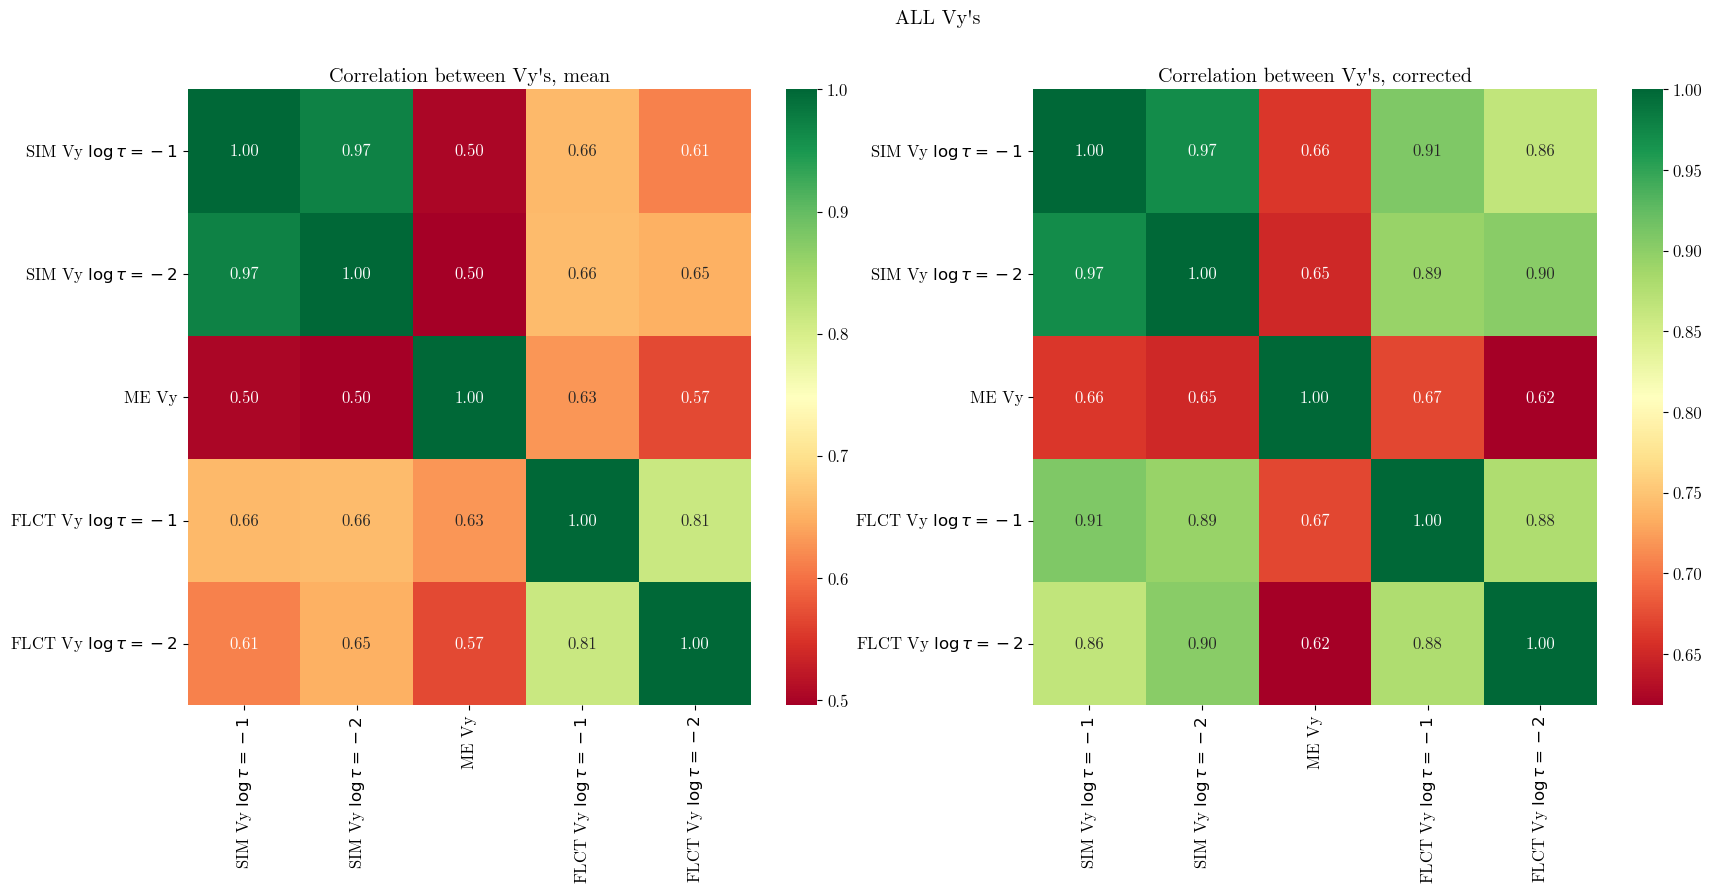

In [40]:
correlation_matrix = np.corrcoef([Vym1_filtered300[:,:].ravel(), Vym2_filtered300[:,:].ravel(),
                     Vy_BzFeI3_mean[:,:].ravel(), Vy_Bz1_mean[:,:].ravel(), 
                     Vy_Bz2_mean[:,:].ravel()])
fig = plt.figure(figsize = (20,8))
fig.suptitle("ALL Vy\'s")
ax1 = fig.add_subplot(121)
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='RdYlGn',
            xticklabels=['SIM Vy $\log\\tau = -1$', 'SIM Vy $\log\\tau = -2$', 'ME Vy', 'FLCT Vy $\log\\tau = -1$', 'FLCT Vy $\log\\tau = -2$'],
            yticklabels=['SIM Vy $\log\\tau = -1$', 'SIM Vy $\log\\tau = -2$', 'ME Vy', 'FLCT Vy $\log\\tau = -1$', 'FLCT Vy $\log\\tau = -2$'])
plt.title("Correlation between Vy\'s, mean")

correlation_matrix = np.corrcoef([Vym1_filtered300[:,:].ravel(), Vym2_filtered300[:,:].ravel(),
                     Vy_BzFeI_cor3[:,:].ravel(), Vy_Bz1_cor3[:,:].ravel(), 
                     Vy_Bz2_cor3[:,:].ravel()])

ax2 = fig.add_subplot(122)
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='RdYlGn',
            xticklabels=['SIM Vy $\log\\tau = -1$', 'SIM Vy $\log\\tau = -2$', 'ME Vy', 'FLCT Vy $\log\\tau = -1$', 'FLCT Vy $\log\\tau = -2$'],
            yticklabels=['SIM Vy $\log\\tau = -1$', 'SIM Vy $\log\\tau = -2$', 'ME Vy', 'FLCT Vy $\log\\tau = -1$', 'FLCT Vy $\log\\tau = -2$'])
plt.title("Correlation between Vy\'s, corrected")
#plt.savefig("Correlatio_0_MgvsFe.png", dpi = 70)

/tmp/ipykernel_14999/4079104223.py:63: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/tmp/ipykernel_14999/4079104223.py:64: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig("300_600_compFeI.png", dpi = 75, bbox_inches = 'tight')
/home/mistflow/anaconda3/envs/flct/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


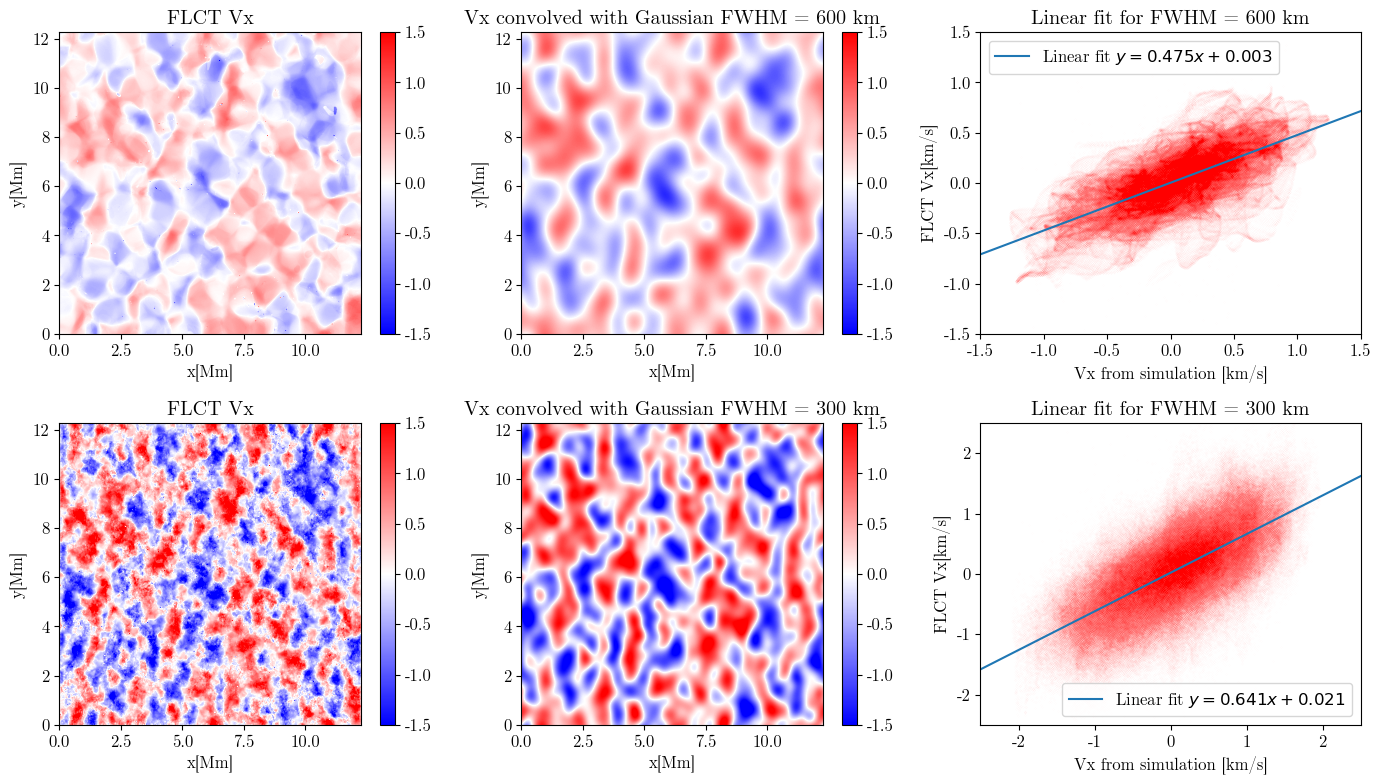

In [41]:
#fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 8))
f = plt.figure(figsize = (14,8))
#plt.suptitle("Linear fit of FLCT Vx and convolved Vx from simulation for FHWM = {1200, 600, 300, 100}km")
# 4x3 plot, velicina A, velicina B, scatter A i B!!!
#ax1 = plt.subplot2grid((4,3), (0,0))
ax1 = f.add_subplot(231)
ax1.set_title("FLCT Vx")
ax1.set_xlabel("x[Mm]")
ax1.set_ylabel("y[Mm]")
im1 = ax1.imshow(Vx_BzFeI_cor[:, :], origin='lower', cmap = "bwr", extent = (0, 12.268, 0, 12.268), vmin = -1.5, vmax = 1.5)
plt.colorbar(im1)

#ax2 = plt.subplot2grid((4,3), (0,1))
ax2 = f.add_subplot(232)
ax2.set_title("Vx convolved with Gaussian FWHM = 600 km")
ax2.set_xlabel("x[Mm]")
ax2.set_ylabel("y[Mm]")
im2 = ax2.imshow(Vxm1_filtered600[:, :], origin='lower', cmap = "bwr", extent = (0, 12.268, 0, 12.268), vmin = -1.5, vmax = 1.5)
plt.colorbar(im2)

#ax3 = plt.subplot2grid((4,3), (0,2))
ax3 = f.add_subplot(233)
ax3.set_title("Linear fit for FWHM = 600 km")                                
ax3.set_ylabel("FLCT Vx[km/s]")
ax3.set_xlabel("Vx from simulation [km/s]")
ax3.scatter(Vxm1_filtered600.flatten(), Vx_BzFeI_cor.flatten(), s = 0.01, alpha = 0.05, color="red")
m1, b1, *_ = linregress(Vxm1_filtered600.flatten(), Vx_BzFeI_cor.flatten())
ax3.axline(xy1=(0, b1), slope=m1, label=f'Linear fit $y = {m1:.3f}x {b1:+.3f}$')
ax3.set_xlim(-1.5, 1.5)
ax3.set_ylim(-1.5, 1.5)
plt.legend()

#ax4 = plt.subplot2grid((4,3), (1,0))
ax4 = f.add_subplot(234)
ax4.set_title("FLCT Vx")
ax4.set_xlabel("x[Mm]")
ax4.set_ylabel("y[Mm]")
im4 = ax4.imshow(Vx_BzFeI_cor3[:, :], origin='lower', cmap = "bwr", extent = (0, 12.268, 0, 12.268), vmin = -1.5, vmax = 1.5)
plt.colorbar(im4)

#ax5 = plt.subplot2grid((4,3), (1,1))
ax5 = f.add_subplot(235)
ax5.set_title("Vx convolved with Gaussian FWHM = 300 km")
ax5.set_xlabel("x[Mm]")
ax5.set_ylabel("y[Mm]")
im5 = ax5.imshow(Vxm1_filtered300[:, :], origin='lower', cmap = "bwr", extent = (0, 12.268, 0, 12.268), vmin = -1.5, vmax = 1.5)
plt.colorbar(im5)

#ax6 = plt.subplot2grid((4,3), (1,2))
ax6 = f.add_subplot(236)
ax6.set_title("Linear fit for FWHM = 300 km")                                
ax6.set_ylabel("FLCT Vx[km/s]")
ax6.set_xlabel("Vx from simulation [km/s]")
ax6.scatter(Vxm1_filtered300.flatten(), Vx_BzFeI_cor3.flatten(), s = 0.01, alpha = 0.05, color="red")
m2, b2, *_ = linregress(Vxm1_filtered300.flatten(), Vx_BzFeI_cor3.flatten())
ax6.axline(xy1=(0, b2), slope=m2, label=f'Linear fit $y = {m2:.3f}x {b2:+.3f}$')
ax6.set_xlim(-2.5, 2.5)
ax6.set_ylim(-2.5, 2.5)
plt.legend()



plt.tight_layout()
plt.savefig("300_600_compFeI.png", dpi = 75, bbox_inches = 'tight')

In [42]:
R = pearsonr(Vxm1_filtered600.flatten(), Vx_BzFeI_cor.flatten())
print(R)

PearsonRResult(statistic=0.6728287644603228, pvalue=0.0)


In [43]:
print(Vxm1_filtered600)

[[0.1270655  0.11759654 0.10873114 ... 0.1582293  0.14746857 0.13705175]
 [0.1464453  0.13743736 0.12898321 ... 0.17594405 0.16578346 0.15592234]
 [0.16562751 0.15708928 0.14905488 ... 0.19343433 0.18388294 0.17458646]
 ...
 [0.06798002 0.0571986  0.047168   ... 0.10391923 0.09143227 0.0794218 ]
 [0.08780847 0.07745104 0.06779575 ... 0.12219816 0.11027228 0.09877891]
 [0.1075118  0.09759243 0.08832608 ... 0.14030786 0.12895802 0.11799648]]


In [44]:
print(Vxm1_filtered300)

[[ 0.05501394 -0.02104228 -0.09656754 ...  0.27698404  0.20491864
   0.13064101]
 [ 0.10885719  0.03446021 -0.03981754 ...  0.32339674  0.25420925
   0.18241206]
 [ 0.1635412   0.09092652  0.01800749 ...  0.37023243  0.30406788
   0.23489115]
 ...
 [-0.09989754 -0.1801528  -0.25874123 ...  0.14156422  0.06186155
  -0.01891919]
 [-0.04949421 -0.12848356 -0.20616564 ...  0.18596467  0.10862984
   0.0298512 ]
 [ 0.00218186 -0.07540651 -0.152067   ...  0.23113464  0.15634935
   0.07974138]]


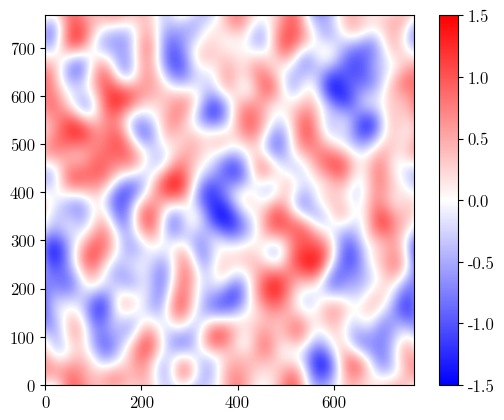

In [45]:
plt.imshow(Vxm1_filtered600[:,:], origin = "lower", cmap = "bwr", vmin = -1.5, vmax = 1.5)
plt.colorbar()

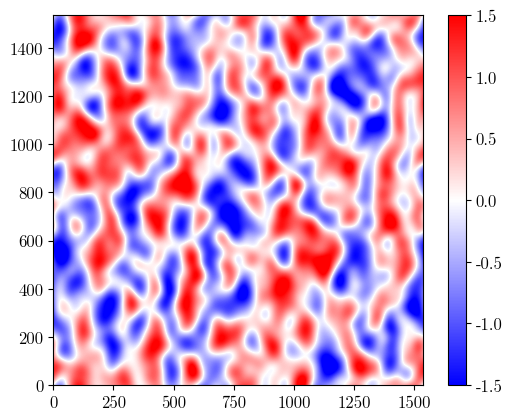

In [46]:
V1 = fits.open("Velocities_TAU_0_1.fits")[1].data
V1= V1[::3]
V1 = V1.transpose(0, 2, 1)
V1_mean = temporal_avg(V1, 0, 90)
V1_mean = V1_mean/1E5
V1600 = gaussian_filter(V1_mean, 22.5, mode = "wrap")
plt.imshow(V1600[:,:], origin = "lower", cmap = "bwr", vmin = -1.5, vmax = 1.5)
plt.colorbar()

In [47]:
print(np.mean(Vxm1_filtered600))
print(np.mean(V1600))

0.051490087
0.051488798


<h2 style ="color:red; font-family:cursive">The correlation depending on sigma in gaussian_filter<br>
    3. row of ALL VX's corrected matrix
</h2>

<h3> $\sigma$ = 22.5/2 or 11.25/2: </h3>

<p>
   FWHM = 600 km - 0.60 | 0.64 | 1.00 | 0.65 | 0.67
</p>

<p>
   FWHM = 300 km - 0.61 | 0.63 | 1.00 | 0.65 | 0.66
</p>

Linear fits: 0.26 (600) | 0.48 (300)

<p>------------------------------------------------------------------------------------------</p>

<h3> $\sigma$ = 22.5/$\sqrt(2)$ or 11.25/$\sqrt(2)$: </h3>

<p>
   FWHM = 600 km - 0.65 | 0.68 | 1.00 | 0.65 | 0.67
</p>

<p>
   FWHM = 300 km - 0.67 | 0.67 | 1.00 | 0.68 | 0.63
</p>

Linear fits: 0.35 (600) | 0.57 (300)

<p>------------------------------------------------------------------------------------------</p>

<h3> $\sigma$ = 22.5 or 11.25: </h3>

<p>
   FWHM = 600 km - 0.67 | 0.65 | 1.00 | 0.69 | 0.67
</p>

<p>
   FWHM = 300 km - 0.67 | 0.67 | 1.00 | 0.68 | 0.63
</p>

Linear fits: 0.47 (600) | 0.64 (300)

<p>------------------------------------------------------------------------------------------</p>

<h3> $\sigma$ = 22.5*2 or 11.25*2: </h3>

<p>
   FWHM = 600 km - 0.59 | 0.61 | 1.00 | 0.65 | 0.67
</p>

<p>
   FWHM = 300 km - 0.61 | 0.60 | 1.00 | 0.68 | 0.63
</p>

Linear fits: 0.79 (600) | 0.95 (300)

<p>------------------------------------------------------------------------------------------</p>

<h3> $\sigma$ = 20 or 10: </h3>

<p>
   FWHM = 600 km - 0.67 | 0.69 | 1.00 | 0.65 | 0.67
</p>

<p>
   FWHM = 300 km - 0.67 | 0.67 | 1.00 | 0.68 | 0.63
</p>

Linear fits: 0.43 (600) | 0.60 (300)

<p>------------------------------------------------------------------------------------------</p>

<h3> $\sigma$ = 17 or 8: </h3>

<p>
   FWHM = 600 km - 0.65 | 0.68 | 1.00 | 0.65 | 0.67
</p>


<p>
   FWHM = 300 km - 0.67 | 0.67 | 1.00 | 0.68 | 0.63
</p>

Linear fits: 0.37 (600) | 0.55 (300)

<p>------------------------------------------------------------------------------------------</p>

<h3>$\sigma$ = 16 or 7:</h3>

<p>
   FWHM = 600 km - 0.65 | 0.68 | 1.00 | 0.65 | 0.67
</p>

<p>
   FWHM = 600 km - 0.66 | 0.67 | 1.00 | 0.68 | 0.63
</p>

Linear fits: 0.35 (600) | 0.52 (300)

<p>------------------------------------------------------------------------------------------</p>

<h2>17. 03. 2025.</h2>
<h2>The rest of optical depths</h2>

In [48]:
Vxm3 = fits.open("Velocities_TAU_0_001.fits")[1].data # Vy from Velocities.fits as originally thought
Vym3 = fits.open("Velocities_TAU_0_001.fits")[0].data # Vx from Velocities.fits as originally thought
Vxm3 = Vxm3[::3,::2,::2]/1E5
Vym3 = Vym3[::3,::2,::2]/1E5
Vxm3 = Vxm3.transpose(0, 2, 1)
Vym3 = Vym3.transpose(0, 2, 1)

In [49]:
Vxm4 = fits.open("Velocities_TAU_0_0001.fits")[1].data # Vy from Velocities.fits as originally thought
Vym4 = fits.open("Velocities_TAU_0_0001.fits")[0].data # Vx from Velocities.fits as originally thought
Vxm4 = Vxm4[::3,::2,::2]/1E5
Vym4 = Vym4[::3,::2,::2]/1E5
Vxm4 = Vxm4.transpose(0, 2, 1)
Vym4 = Vym4.transpose(0, 2, 1)

In [50]:
Vx_Bz3 = fits.open("pyFLCT_vx_vy_fwhm_600_dt_30_logTaum3Bz_tracked.fits")[0].data
Vy_Bz3 = fits.open("pyFLCT_vx_vy_fwhm_600_dt_30_logTaum3Bz_tracked.fits")[1].data
Vx_Bz3 = Vx_Bz3[:30,::2,::2]
Vy_Bz3 = Vy_Bz3[:30,::2,::2]

In [51]:
Vx_Bz4 = fits.open("pyFLCT_vx_vy_fwhm_600_dt_30_logTaum4Bz_tracked.fits")[0].data
Vy_Bz4 = fits.open("pyFLCT_vx_vy_fwhm_600_dt_30_logTaum4Bz_tracked.fits")[1].data
Vx_Bz4 = Vx_Bz4[:30,::2,::2]
Vy_Bz4 = Vy_Bz4[:30,::2,::2]

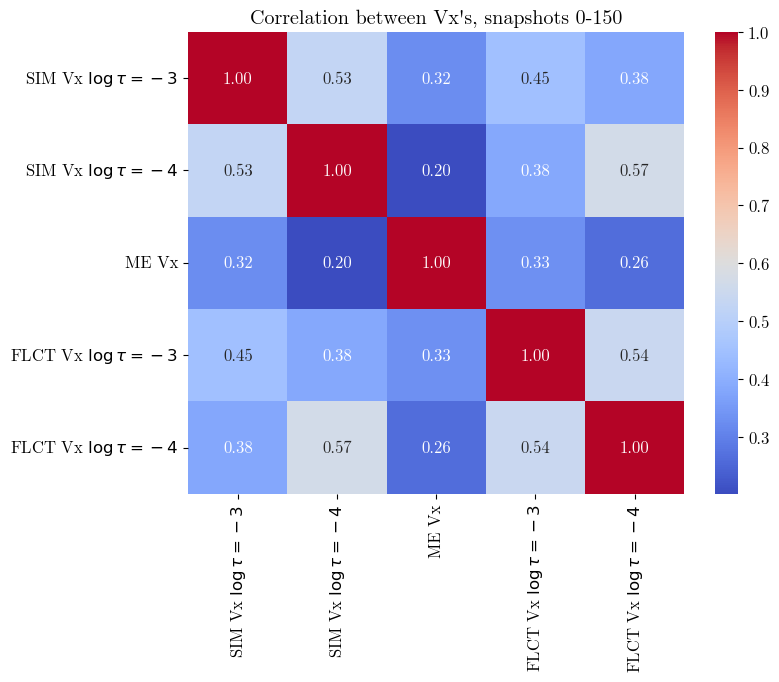

In [52]:
correlation_matrix = np.corrcoef([Vxm3[0,:,:].ravel(), Vxm4[0, :,:].ravel(),
                     Vx_ME_FeI[0,:,:].ravel(), Vx_Bz3[0,:,:].ravel(), 
                     Vx_Bz4[0,:,:].ravel()]) 

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm',
            xticklabels=['SIM Vx $\log\\tau = -3$', 'SIM Vx $\log\\tau = -4$', 'ME Vx', 'FLCT Vx $\log\\tau = -3$', 'FLCT Vx $\log\\tau = -4$'],
            yticklabels=['SIM Vx $\log\\tau = -3$', 'SIM Vx $\log\\tau = -4$', 'ME Vx', 'FLCT Vx $\log\\tau = -3$', 'FLCT Vx $\log\\tau = -4$'])
plt.title("Correlation between Vx\'s, snapshots 0-150")
plt.savefig("Vx_FE_cor_rest.png", dpi = 70)
plt.show()

In [53]:
Vxm3_mean = temporal_avg(Vxm3, 0, 90)
#Vxm1_mean = Vxm1_mean/1E5
Vym3_mean = temporal_avg(Vym3, 0, 90)
#Vym1_mean = Vym1_mean/1E5

In [54]:
Vxm4_mean = temporal_avg(Vxm4, 0, 90)
#Vxm1_mean = Vxm1_mean/1E5
Vym4_mean = temporal_avg(Vym4, 0, 90)
#Vym1_mean = Vym1_mean/1E5

In [55]:
Vxm3_filtered600 = gaussian_filter(Vxm3_mean, 22.5, mode = "wrap")
Vym3_filtered600 = gaussian_filter(Vym3_mean, 22.5, mode = "wrap")

In [56]:
Vxm4_filtered600 = gaussian_filter(Vxm4_mean, 22.5, mode = "wrap")
Vym4_filtered600 = gaussian_filter(Vym4_mean, 22.5, mode = "wrap")

In [57]:
Vx_Bz3_cor = mean_v_from_file("pyFLCT_vx_vy_fwhm_600_dt_30_logTaum3Bz_tracked.fits")
Vy_Bz3_cor = mean_vy_from_file("pyFLCT_vx_vy_fwhm_600_dt_30_logTaum3Bz_tracked.fits")

In [58]:
Vx_Bz4_cor = mean_v_from_file("pyFLCT_vx_vy_fwhm_600_dt_30_logTaum4Bz_tracked.fits")
Vy_Bz4_cor = mean_vy_from_file("pyFLCT_vx_vy_fwhm_600_dt_30_logTaum4Bz_tracked.fits")

In [59]:
Vx_Bz3_cor = Vx_Bz3_cor[::2,::2]
Vy_Bz3_cor = Vy_Bz3_cor[::2,::2]

In [60]:
Vx_Bz4_cor = Vx_Bz4_cor[::2,::2]
Vy_Bz4_cor = Vy_Bz4_cor[::2,::2]

In [61]:
Vx_Bz3_mean = temporal_avg(Vx_Bz3, 0, 90)
Vy_Bz3_mean = temporal_avg(Vy_Bz3, 0, 90)
#Vx_Bz1_mean = Vx_Bz1_mean[::2,::2]
#Vy_Bz1_mean = Vy_Bz1_mean[::2,::2]

In [62]:
Vx_Bz4_mean = temporal_avg(Vx_Bz4, 0, 90)
Vy_Bz4_mean = temporal_avg(Vy_Bz4, 0, 90)
#Vx_Bz1_mean = Vx_Bz1_mean[::2,::2]
#Vy_Bz1_mean = Vy_Bz1_mean[::2,::2]

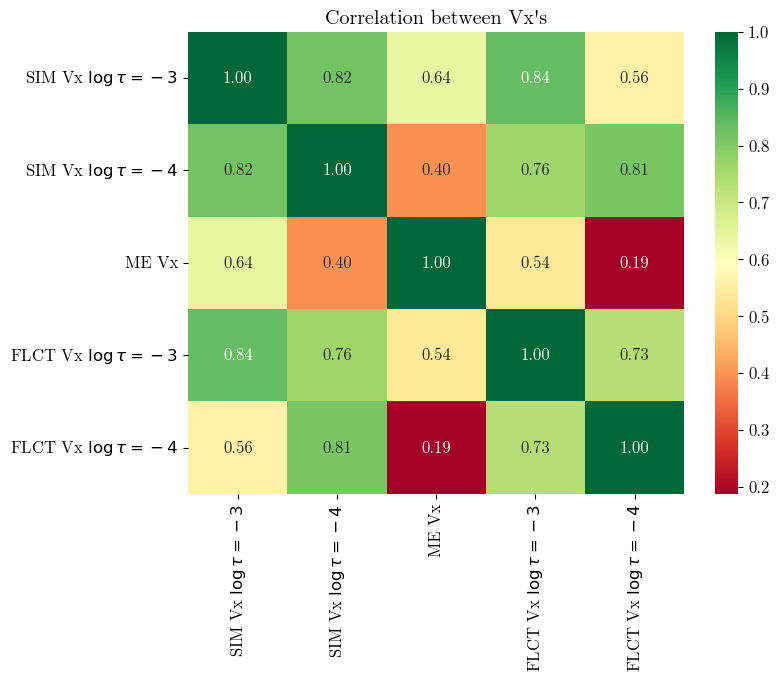

In [63]:
correlation_matrix = np.corrcoef([Vxm3_filtered600[:,:].ravel(), Vxm4_filtered600[:,:].ravel(),
                     Vx_BzFeI_cor[:,:].ravel(), Vx_Bz3_cor[:,:].ravel(), 
                     Vx_Bz4_cor[:,:].ravel()]) 

fig = plt.figure(figsize = (8,6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='RdYlGn',
            xticklabels=['SIM Vx $\log\\tau = -3$', 'SIM Vx $\log\\tau = -4$', 'ME Vx', 'FLCT Vx $\log\\tau = -3$', 'FLCT Vx $\log\\tau = -4$'],
            yticklabels=['SIM Vx $\log\\tau = -3$', 'SIM Vx $\log\\tau = -4$', 'ME Vx', 'FLCT Vx $\log\\tau = -3$', 'FLCT Vx $\log\\tau = -4$'])
plt.title("Correlation between Vx\'s")
plt.savefig("rest_Averaged_cor_vel.png", dpi = 70)
plt.show()

Text(0.5, 1.0, "Correlation between Vx's, corrected")

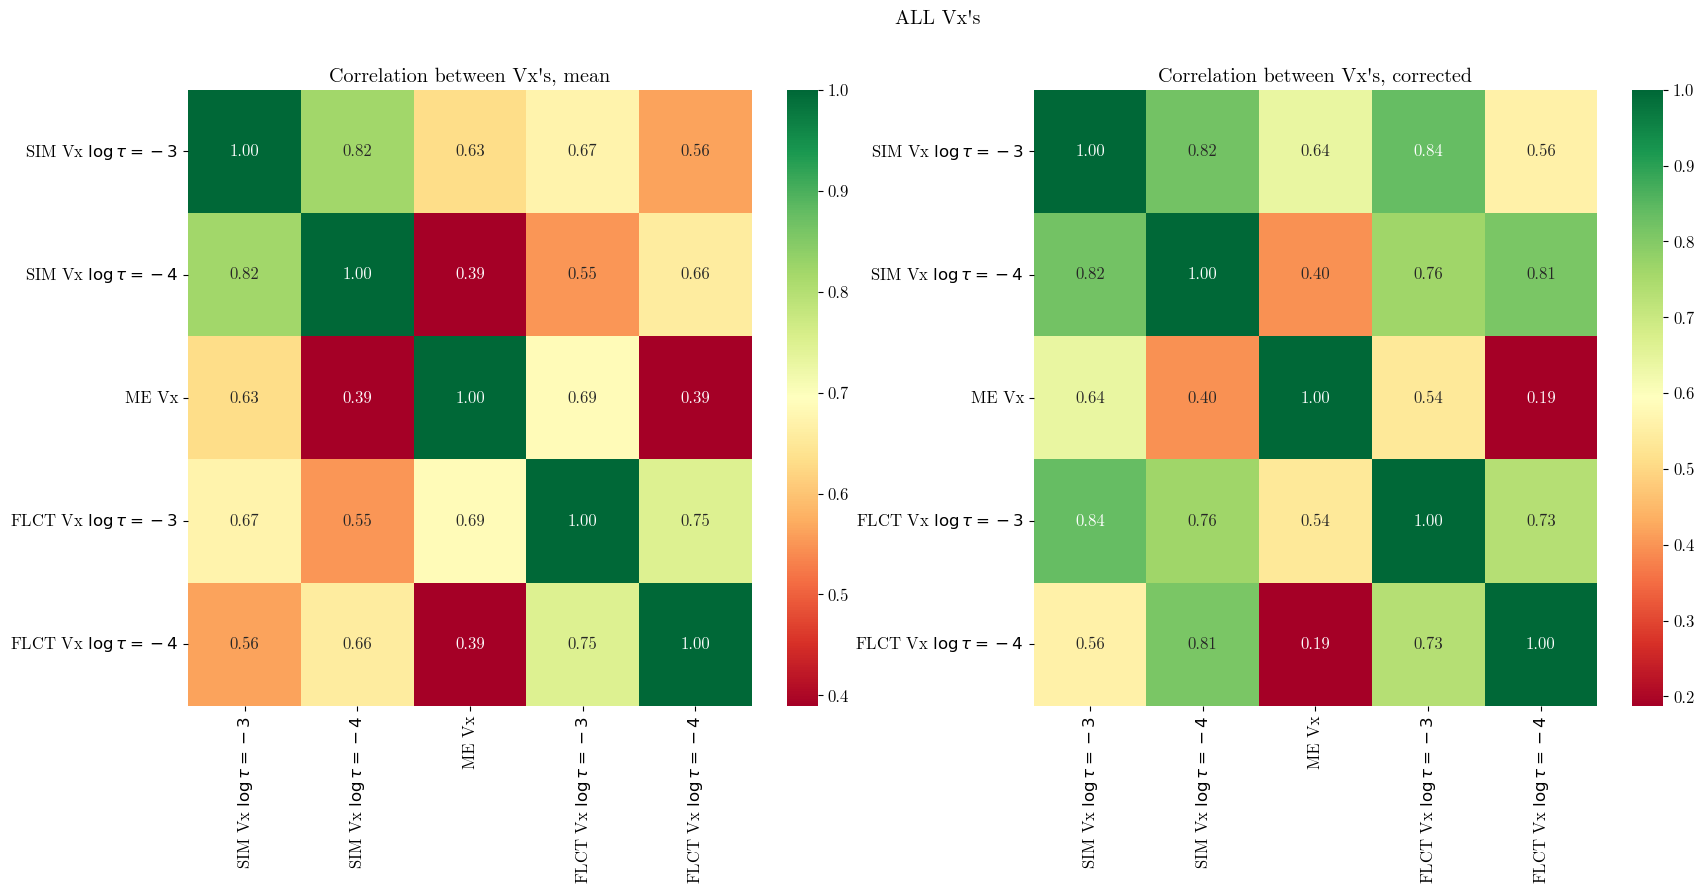

In [64]:
correlation_matrix = np.corrcoef([Vxm3_filtered600[:,:].ravel(), Vxm4_filtered600[:,:].ravel(),
                     Vx_BzFeI_mean[:,:].ravel(), Vx_Bz3_mean[:,:].ravel(), 
                     Vx_Bz4_mean[:,:].ravel()])
fig = plt.figure(figsize = (20,8))
fig.suptitle("ALL Vx\'s")
ax1 = fig.add_subplot(121)
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='RdYlGn',
            xticklabels=['SIM Vx $\log\\tau = -3$', 'SIM Vx $\log\\tau = -4$', 'ME Vx', 'FLCT Vx $\log\\tau = -3$', 'FLCT Vx $\log\\tau = -4$'],
            yticklabels=['SIM Vx $\log\\tau = -3$', 'SIM Vx $\log\\tau = -4$', 'ME Vx', 'FLCT Vx $\log\\tau = -3$', 'FLCT Vx $\log\\tau = -4$'])
plt.title("Correlation between Vx\'s, mean")

correlation_matrix = np.corrcoef([Vxm3_filtered600[:,:].ravel(), Vxm4_filtered600[:,:].ravel(),
                     Vx_BzFeI_cor[:,:].ravel(), Vx_Bz3_cor[:,:].ravel(), 
                     Vx_Bz4_cor[:,:].ravel()])

ax2 = fig.add_subplot(122)
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='RdYlGn',
            xticklabels=['SIM Vx $\log\\tau = -3$', 'SIM Vx $\log\\tau = -4$', 'ME Vx', 'FLCT Vx $\log\\tau = -3$', 'FLCT Vx $\log\\tau = -4$'],
            yticklabels=['SIM Vx $\log\\tau = -3$', 'SIM Vx $\log\\tau = -4$', 'ME Vx', 'FLCT Vx $\log\\tau = -3$', 'FLCT Vx $\log\\tau = -4$'])
plt.title("Correlation between Vx\'s, corrected")
#plt.savefig("Correlatio_0_MgvsFe.png", dpi = 70)

Text(0.5, 1.0, "Correlation between Vy's, corrected")

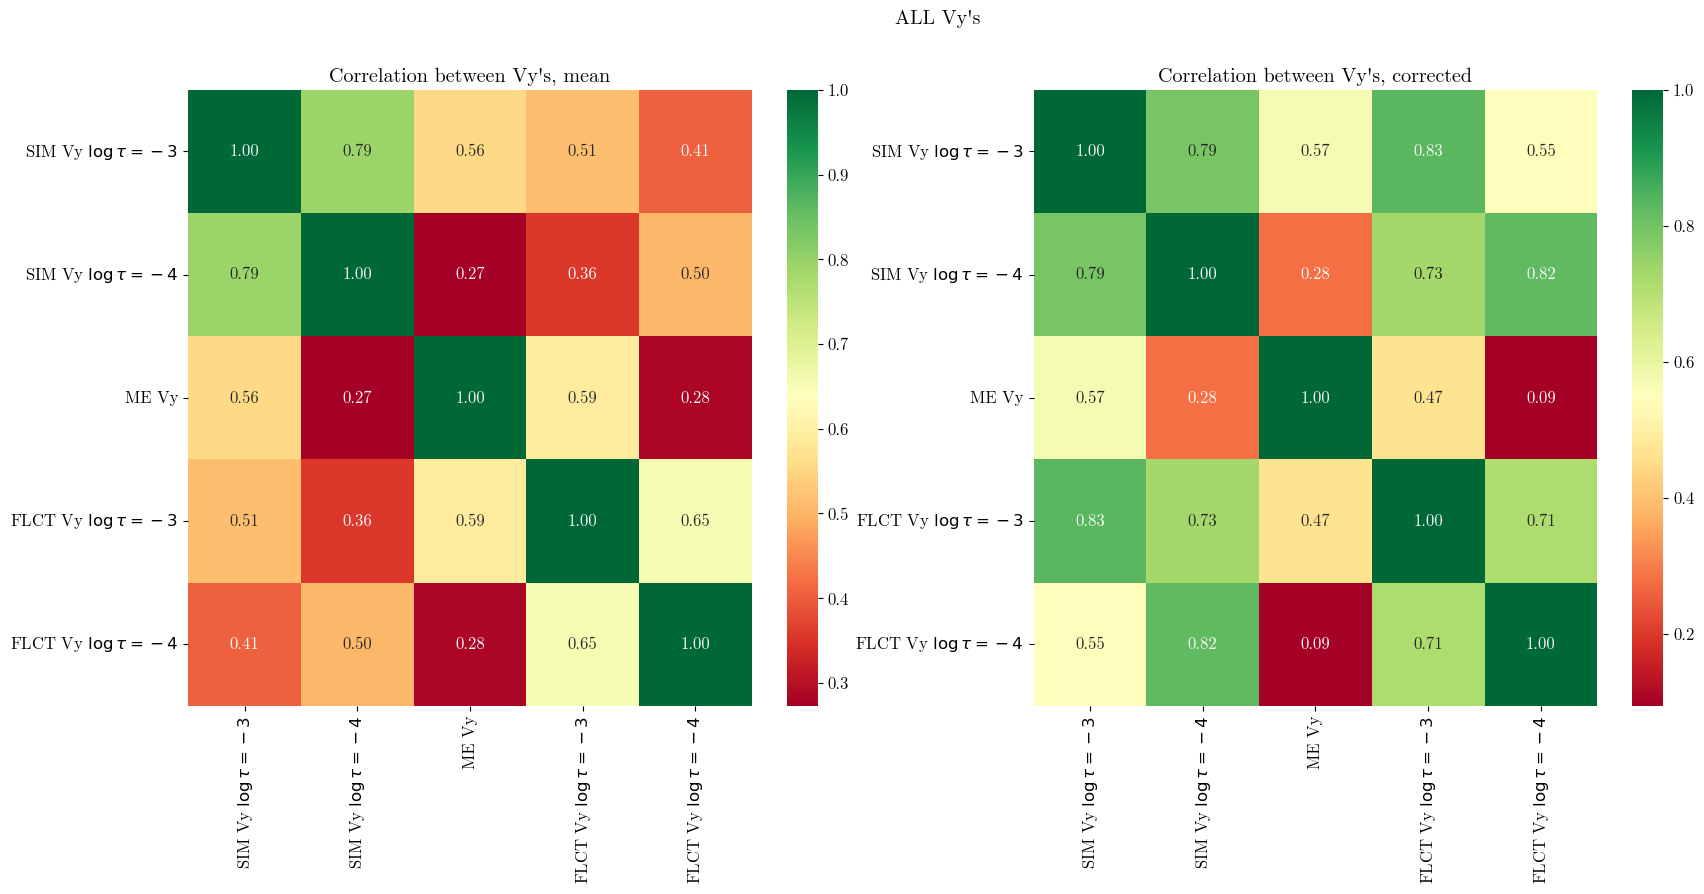

In [65]:
correlation_matrix = np.corrcoef([Vym3_filtered600[:,:].ravel(), Vym4_filtered600[:,:].ravel(),
                     Vy_BzFeI_mean[:,:].ravel(), Vy_Bz3_mean[:,:].ravel(), 
                     Vy_Bz4_mean[:,:].ravel()])
fig = plt.figure(figsize = (20,8))
fig.suptitle("ALL Vy\'s")
ax1 = fig.add_subplot(121)
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='RdYlGn',
            xticklabels=['SIM Vy $\log\\tau = -3$', 'SIM Vy $\log\\tau = -4$', 'ME Vy', 'FLCT Vy $\log\\tau = -3$', 'FLCT Vy $\log\\tau = -4$'],
            yticklabels=['SIM Vy $\log\\tau = -3$', 'SIM Vy $\log\\tau = -4$', 'ME Vy', 'FLCT Vy $\log\\tau = -3$', 'FLCT Vy $\log\\tau = -4$'])
plt.title("Correlation between Vy\'s, mean")

correlation_matrix = np.corrcoef([Vym3_filtered600[:,:].ravel(), Vym4_filtered600[:,:].ravel(),
                     Vy_BzFeI_cor[:,:].ravel(), Vy_Bz3_cor[:,:].ravel(), 
                     Vy_Bz4_cor[:,:].ravel()])

ax2 = fig.add_subplot(122)
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='RdYlGn',
            xticklabels=['SIM Vy $\log\\tau = -3$', 'SIM Vy $\log\\tau = -4$', 'ME Vy', 'FLCT Vy $\log\\tau = -3$', 'FLCT Vy $\log\\tau = -4$'],
            yticklabels=['SIM Vy $\log\\tau = -3$', 'SIM Vy $\log\\tau = -4$', 'ME Vy', 'FLCT Vy $\log\\tau = -3$', 'FLCT Vy $\log\\tau = -4$'])
plt.title("Correlation between Vy\'s, corrected")
#plt.savefig("Correlatio_0_MgvsFe.png", dpi = 70)

<h3>FWHM = 300 km</h3>

In [66]:
Vxm3_filtered300 = gaussian_filter(Vxm3_mean, 11.25, mode = "wrap")
Vym3_filtered300 = gaussian_filter(Vym3_mean, 11.25, mode = "wrap")

In [67]:
Vxm4_filtered300 = gaussian_filter(Vxm4_mean, 11.25, mode = "wrap")
Vym4_filtered300 = gaussian_filter(Vym4_mean, 11.25, mode = "wrap")

In [68]:
Vx_Bz3_cor3 = mean_v_from_file("pyFLCT_vx_vy_fwhm_300_dt_30_logTaum3Bz_tracked.fits")
Vy_Bz3_cor3 = mean_vy_from_file("pyFLCT_vx_vy_fwhm_300_dt_30_logTaum3Bz_tracked.fits")

In [69]:
Vx_Bz4_cor3 = mean_v_from_file("pyFLCT_vx_vy_fwhm_300_dt_30_logTaum4Bz_tracked.fits")
Vy_Bz4_cor3 = mean_vy_from_file("pyFLCT_vx_vy_fwhm_300_dt_30_logTaum4Bz_tracked.fits")

In [70]:
Vx_Bz3_cor3 = Vx_Bz3_cor3[::2,::2]
Vy_Bz3_cor3 = Vy_Bz3_cor3[::2,::2]

In [71]:
Vx_Bz4_cor3 = Vx_Bz4_cor3[::2,::2]
Vy_Bz4_cor3 = Vy_Bz4_cor3[::2,::2]

Text(0.5, 1.0, "Correlation between Vx's, corrected")

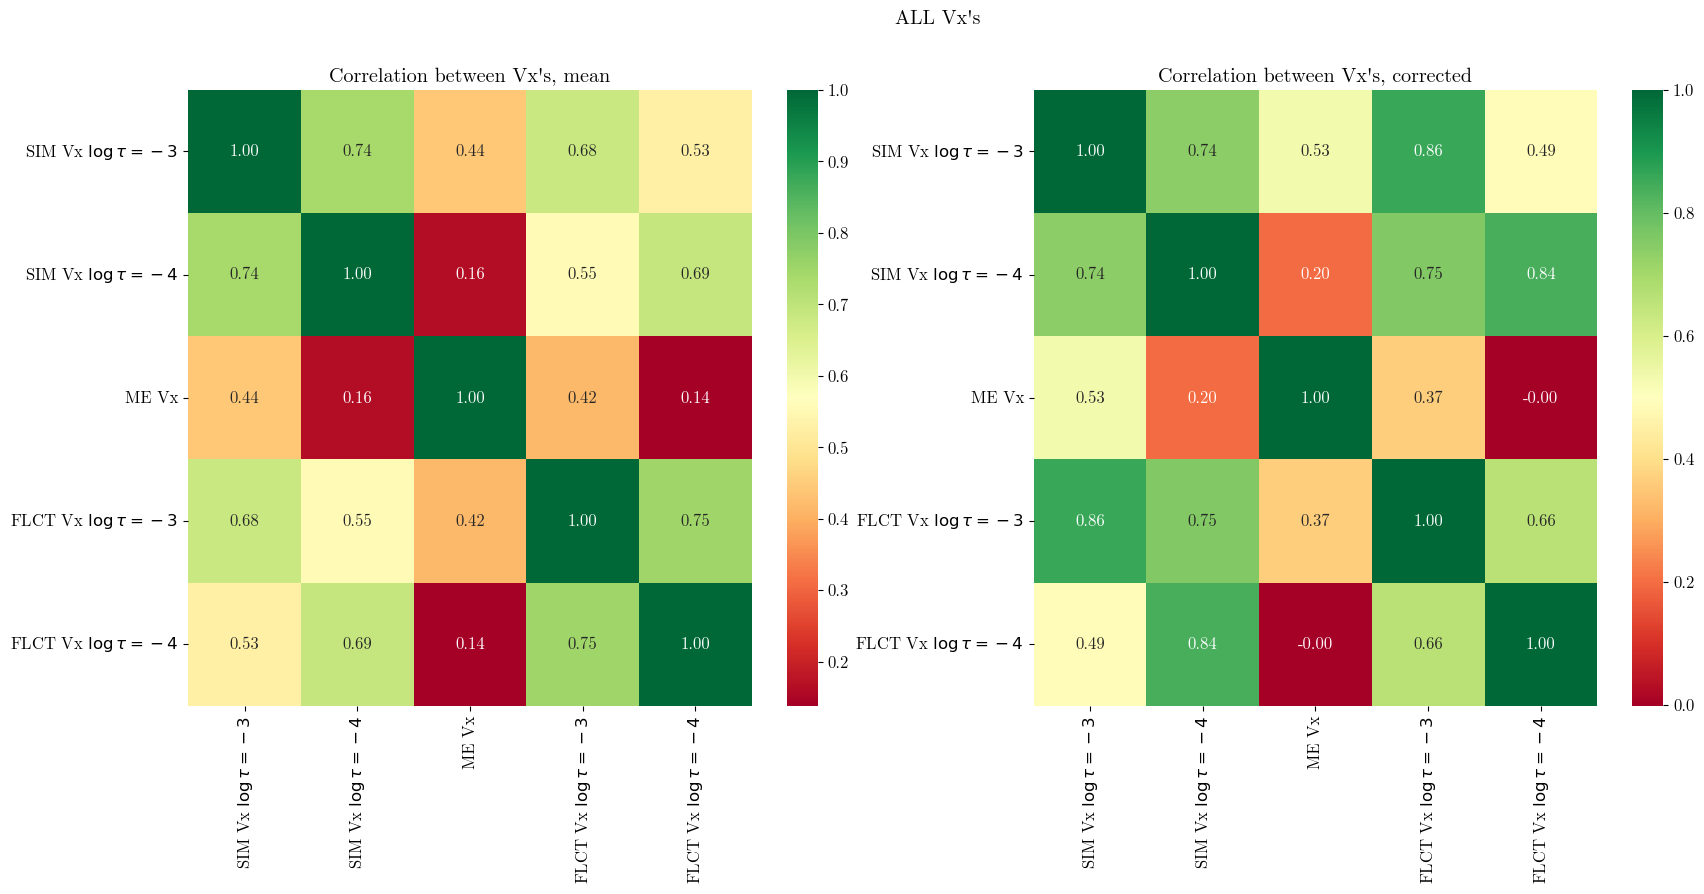

In [72]:
correlation_matrix = np.corrcoef([Vxm3_filtered300[:,:].ravel(), Vxm4_filtered300[:,:].ravel(),
                     Vx_BzFeI3_mean[:,:].ravel(), Vx_Bz3_mean[:,:].ravel(), 
                     Vx_Bz4_mean[:,:].ravel()])
fig = plt.figure(figsize = (20,8))
fig.suptitle("ALL Vx\'s")
ax1 = fig.add_subplot(121)
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='RdYlGn',
            xticklabels=['SIM Vx $\log\\tau = -3$', 'SIM Vx $\log\\tau = -4$', 'ME Vx', 'FLCT Vx $\log\\tau = -3$', 'FLCT Vx $\log\\tau = -4$'],
            yticklabels=['SIM Vx $\log\\tau = -3$', 'SIM Vx $\log\\tau = -4$', 'ME Vx', 'FLCT Vx $\log\\tau = -3$', 'FLCT Vx $\log\\tau = -4$'])
plt.title("Correlation between Vx\'s, mean")

correlation_matrix = np.corrcoef([Vxm3_filtered300[:,:].ravel(), Vxm4_filtered300[:,:].ravel(),
                     Vx_BzFeI_cor3[:,:].ravel(), Vx_Bz3_cor3[:,:].ravel(), 
                     Vx_Bz4_cor3[:,:].ravel()])

ax2 = fig.add_subplot(122)
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='RdYlGn',
            xticklabels=['SIM Vx $\log\\tau = -3$', 'SIM Vx $\log\\tau = -4$', 'ME Vx', 'FLCT Vx $\log\\tau = -3$', 'FLCT Vx $\log\\tau = -4$'],
            yticklabels=['SIM Vx $\log\\tau = -3$', 'SIM Vx $\log\\tau = -4$', 'ME Vx', 'FLCT Vx $\log\\tau = -3$', 'FLCT Vx $\log\\tau = -4$'])
plt.title("Correlation between Vx\'s, corrected")
#plt.savefig("Correlatio_0_MgvsFe.png", dpi = 70)

Text(0.5, 1.0, "Correlation between Vy's, corrected")

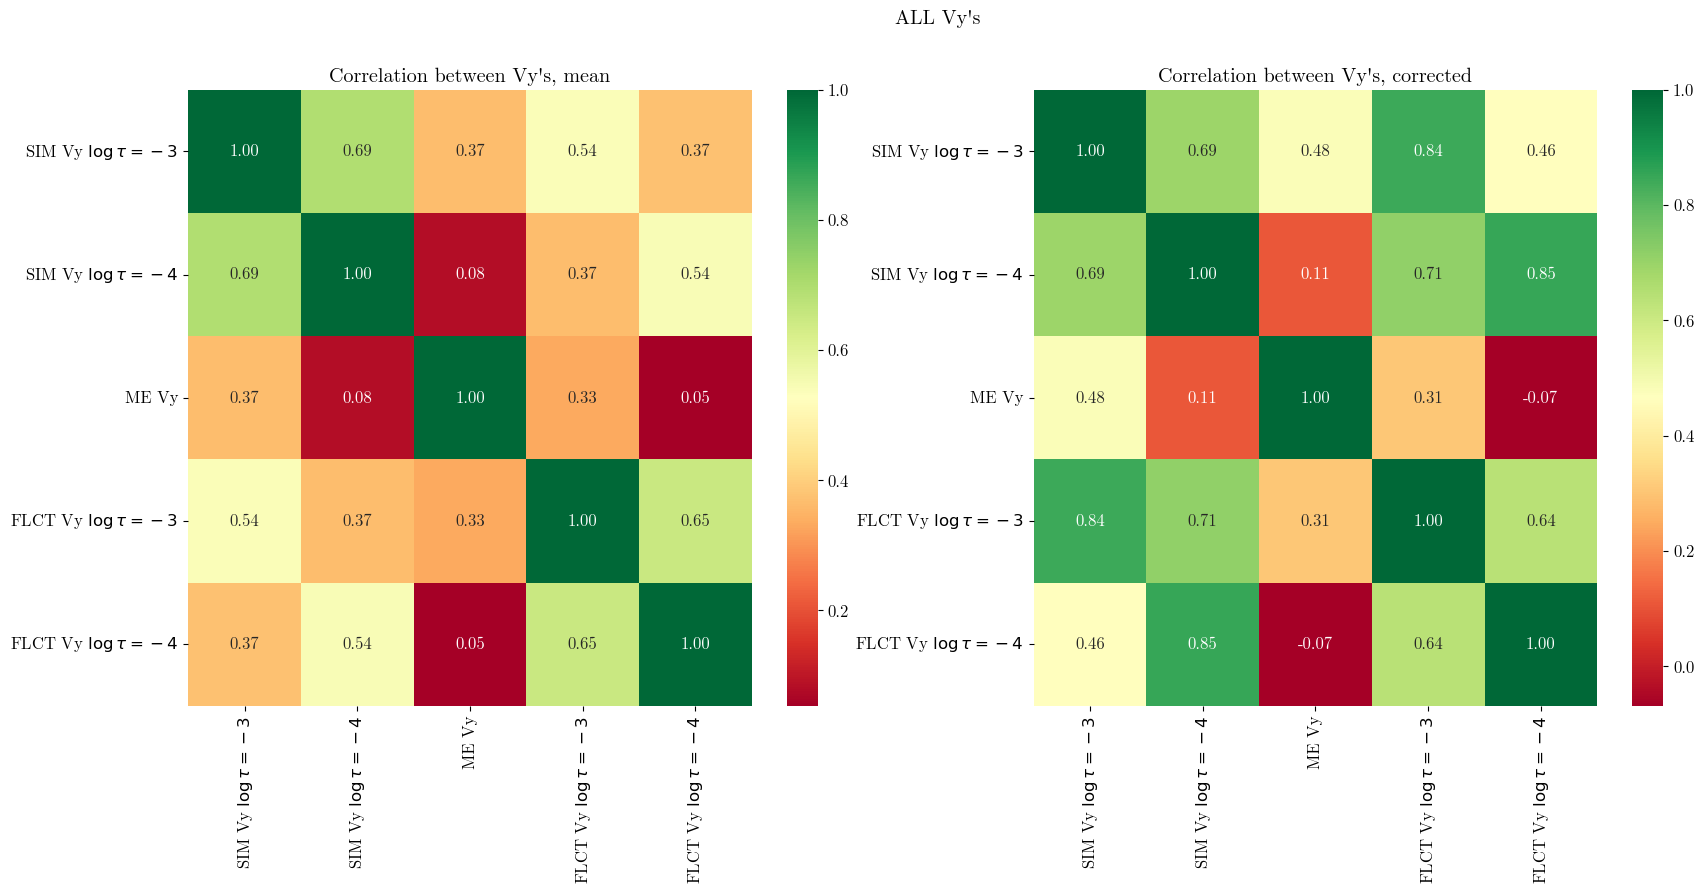

In [73]:
correlation_matrix = np.corrcoef([Vym3_filtered300[:,:].ravel(), Vym4_filtered300[:,:].ravel(),
                     Vy_BzFeI3_mean[:,:].ravel(), Vy_Bz3_mean[:,:].ravel(), 
                     Vy_Bz4_mean[:,:].ravel()])
fig = plt.figure(figsize = (20,8))
fig.suptitle("ALL Vy\'s")
ax1 = fig.add_subplot(121)
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='RdYlGn',
            xticklabels=['SIM Vy $\log\\tau = -3$', 'SIM Vy $\log\\tau = -4$', 'ME Vy', 'FLCT Vy $\log\\tau = -3$', 'FLCT Vy $\log\\tau = -4$'],
            yticklabels=['SIM Vy $\log\\tau = -3$', 'SIM Vy $\log\\tau = -4$', 'ME Vy', 'FLCT Vy $\log\\tau = -3$', 'FLCT Vy $\log\\tau = -4$'])
plt.title("Correlation between Vy\'s, mean")

correlation_matrix = np.corrcoef([Vym3_filtered300[:,:].ravel(), Vym4_filtered300[:,:].ravel(),
                     Vy_BzFeI_cor3[:,:].ravel(), Vy_Bz3_cor3[:,:].ravel(), 
                     Vy_Bz4_cor3[:,:].ravel()])

ax2 = fig.add_subplot(122)
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='RdYlGn',
            xticklabels=['SIM Vy $\log\\tau = -3$', 'SIM Vy $\log\\tau = -4$', 'ME Vy', 'FLCT Vy $\log\\tau = -3$', 'FLCT Vy $\log\\tau = -4$'],
            yticklabels=['SIM Vy $\log\\tau = -3$', 'SIM Vy $\log\\tau = -4$', 'ME Vy', 'FLCT Vy $\log\\tau = -3$', 'FLCT Vy $\log\\tau = -4$'])
plt.title("Correlation between Vy\'s, corrected")
#plt.savefig("Correlatio_0_MgvsFe.png", dpi = 70)

/tmp/ipykernel_14999/158563166.py:63: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/tmp/ipykernel_14999/158563166.py:64: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig("300_600_compFeI_taum3.png", dpi = 75, bbox_inches = 'tight')
/home/mistflow/anaconda3/envs/flct/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


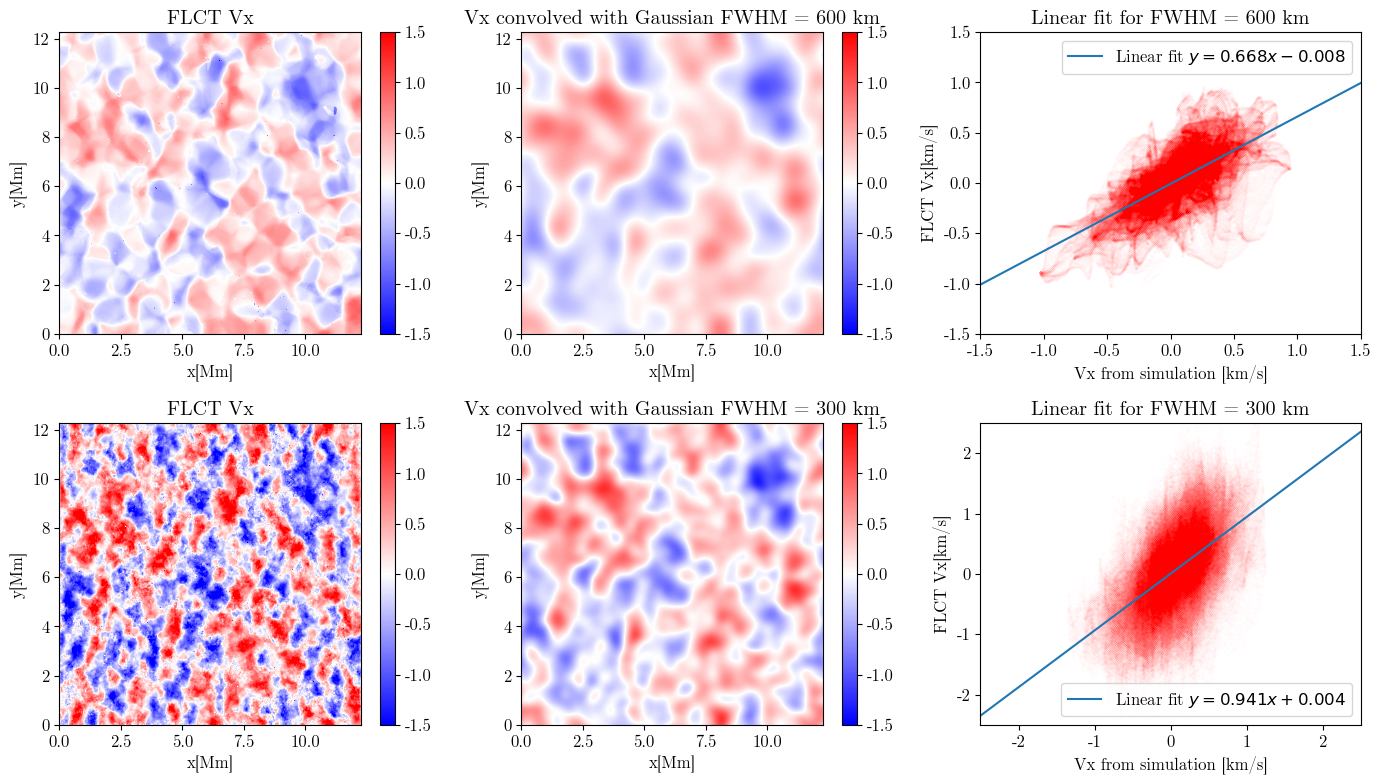

In [74]:
#fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 8))
f = plt.figure(figsize = (14,8))
#plt.suptitle("Linear fit of FLCT Vx and convolved Vx from simulation for FHWM = {1200, 600, 300, 100}km")
# 4x3 plot, velicina A, velicina B, scatter A i B!!!
#ax1 = plt.subplot2grid((4,3), (0,0))
ax1 = f.add_subplot(231)
ax1.set_title("FLCT Vx")
ax1.set_xlabel("x[Mm]")
ax1.set_ylabel("y[Mm]")
im1 = ax1.imshow(Vx_BzFeI_cor[:, :], origin='lower', cmap = "bwr", extent = (0, 12.268, 0, 12.268), vmin = -1.5, vmax = 1.5)
plt.colorbar(im1)

#ax2 = plt.subplot2grid((4,3), (0,1))
ax2 = f.add_subplot(232)
ax2.set_title("Vx convolved with Gaussian FWHM = 600 km")
ax2.set_xlabel("x[Mm]")
ax2.set_ylabel("y[Mm]")
im2 = ax2.imshow(Vxm3_filtered600[:, :], origin='lower', cmap = "bwr", extent = (0, 12.268, 0, 12.268), vmin = -1.5, vmax = 1.5)
plt.colorbar(im2)

#ax3 = plt.subplot2grid((4,3), (0,2))
ax3 = f.add_subplot(233)
ax3.set_title("Linear fit for FWHM = 600 km")                                
ax3.set_ylabel("FLCT Vx[km/s]")
ax3.set_xlabel("Vx from simulation [km/s]")
ax3.scatter(Vxm3_filtered600.flatten(), Vx_BzFeI_cor.flatten(), s = 0.01, alpha = 0.05, color="red")
m3, b3, *_ = linregress(Vxm3_filtered600.flatten(), Vx_BzFeI_cor.flatten())
ax3.axline(xy1=(0, b3), slope=m3, label=f'Linear fit $y = {m3:.3f}x {b3:+.3f}$')
ax3.set_xlim(-1.5, 1.5)
ax3.set_ylim(-1.5, 1.5)
plt.legend()

#ax4 = plt.subplot2grid((4,3), (1,0))
ax4 = f.add_subplot(234)
ax4.set_title("FLCT Vx")
ax4.set_xlabel("x[Mm]")
ax4.set_ylabel("y[Mm]")
im4 = ax4.imshow(Vx_BzFeI_cor3[:, :], origin='lower', cmap = "bwr", extent = (0, 12.268, 0, 12.268), vmin = -1.5, vmax = 1.5)
plt.colorbar(im4)

#ax5 = plt.subplot2grid((4,3), (1,1))
ax5 = f.add_subplot(235)
ax5.set_title("Vx convolved with Gaussian FWHM = 300 km")
ax5.set_xlabel("x[Mm]")
ax5.set_ylabel("y[Mm]")
im5 = ax5.imshow(Vxm3_filtered300[:, :], origin='lower', cmap = "bwr", extent = (0, 12.268, 0, 12.268), vmin = -1.5, vmax = 1.5)
plt.colorbar(im5)

#ax6 = plt.subplot2grid((4,3), (1,2))
ax6 = f.add_subplot(236)
ax6.set_title("Linear fit for FWHM = 300 km")                                
ax6.set_ylabel("FLCT Vx[km/s]")
ax6.set_xlabel("Vx from simulation [km/s]")
ax6.scatter(Vxm3_filtered300.flatten(), Vx_BzFeI_cor3.flatten(), s = 0.01, alpha = 0.05, color="red")
m4, b4, *_ = linregress(Vxm3_filtered300.flatten(), Vx_BzFeI_cor3.flatten())
ax6.axline(xy1=(0, b4), slope=m4, label=f'Linear fit $y = {m4:.3f}x {b4:+.3f}$')
ax6.set_xlim(-2.5, 2.5)
ax6.set_ylim(-2.5, 2.5)
plt.legend()



plt.tight_layout()
plt.savefig("300_600_compFeI_taum3.png", dpi = 75, bbox_inches = 'tight')